# Analysis of a Survey on Calendar Features

This code analyzes the data formed with a survey aiming to find out relations among calendar features, personal time-styles, tool choices, and busyness. Please check README.md for further details.

In [1]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

In [2]:
df_raw = pd.read_csv('./calendar_survey.csv', sep=';')

In [3]:
#Removing answers to statements related with time-styles, since their average is already calculated
df_clean = df_raw.drop(df_raw.iloc[:, 49:74], axis=1)

In [4]:
#Listing personal information on rows with "Other-busyness" & "Other-Tool" entries
df_other = df_clean.dropna(axis=0, how='all', subset=["Other-busyness","Other-Tool"]).iloc[:, 1:16]

In [5]:
df_other

,Date,Full-time-working,Part-time-working,Member-of-NGO,Other-busyness,Digital-skills,Using-calendar,Daybook,Notebook,Desktop-calendar,Wall-mounted-calendar,Mobile-phone,PC,Tablet,Other-Tool
3,26.05.2016 09:27,0,1,0,NaN,5,1,0,0,0,0,1,0,0,Microsoft Office
16,26.05.2016 10:32,0,0,0,NaN,4,1,0,0,1,0,1,0,0,Post-it
21,26.05.2016 11:33,0,0,1,Member of futsal team,5,1,0,0,0,0,1,0,0,NaN
28,26.05.2016 13:53,0,0,0,Private course,2,1,0,0,0,0,1,0,0,NaN
45,26.05.2016 19:45,0,0,0,"Graduated, full-time worker",4,1,0,1,1,0,1,0,0,NaN
52,26.05.2016 21:03,0,0,1,I play online games,5,1,0,0,0,0,1,0,0,NaN
54,26.05.2016 20:46,0,0,0,None,3,0,0,0,0,0,0,0,0,NaN
56,26.05.2016 21:52,0,0,0,I perceive social life as a cause of busyness....,4,0,0,0,0,0,0,0,0,NaN
58,26.05.2016 22:26,0,0,0,Sports,3,1,1,0,0,0,1,0,0,NaN
65,27.05.2016 00:05,0,0,0,"I mean, other.",5,1,0,0,0,0,1,1,0,NaN


In [6]:
#Entering 1 for legitimate entries, while entering 0 for all other rows
df_clean["Other-busyness"] = 0
df_clean.loc[[21, 28, 58, 68, 71, 72, 113, 117, 165, 190], "Other-busyness"] = 1
df_clean["Other-Tool"] = 0
df_clean.loc[[16, 90, 92], "Other-Tool"] = 1
#For row 3 & 101, Other-Tool entries are transferred to PC column
df_clean.loc[[3,101], "PC"] = 1

In [7]:
#Removing Date column, as it won't be used in analysis
df_clean = df_clean.drop("Date", axis=1)

In [8]:
#Listing NaN values on columns
list_nans = df_clean.isna().sum()
df_nans = pd.DataFrame({'feature':list_nans.index, 'nancount':list_nans.values})
df_nans

,feature,nancount
0,ID,0
1,Full-time-working,0
2,Part-time-working,0
3,Member-of-NGO,0
4,Other-busyness,0
5,Digital-skills,0
6,Using-calendar,0
7,Daybook,0
8,Notebook,0
9,Desktop-calendar,0


In [9]:
#Entering 3 (mid-value) for two NaN entries
df_clean.fillna(3)

,ID,Full-time-working,Part-time-working,Member-of-NGO,Other-busyness,Digital-skills,Using-calendar,Daybook,Notebook,Desktop-calendar,...,provides self-fostering,makes me proud,enables self-expression,provides self-confidence,provides the joy of nostalgia,provides the joy of being served,POLY,PLAN,SOCI,TEMP
0,2,0,1,1,0,3,1,1,0,0,...,4,4,3,4,2,3,-0.5,0.25,-0.29,0.3
1,3,1,0,0,0,4,1,0,1,0,...,5,5,3,5,5,5,0.5,0.17,0.71,-0.1
2,5,1,0,0,0,5,1,1,0,0,...,3,3,4,5,5,1,0.1,0.58,0.07,-0.1
3,6,0,1,0,0,5,1,0,0,0,...,4,4,4,4,3,4,0.4,0.17,0.14,0.2
4,7,1,0,0,0,4,1,0,1,0,...,5,3,3,3,3,3,0.5,0.25,0.29,0.3
5,8,0,1,1,0,5,1,0,1,0,...,2,2,3,4,2,4,0.6,0.17,0.36,0.1
6,12,1,0,0,0,3,1,0,0,1,...,3,4,4,3,3,3,0.2,0.50,0.14,0.4
7,15,0,0,1,0,3,0,0,0,0,...,4,3,1,3,4,4,0.5,-0.17,-0.07,0.1
8,16,0,0,1,0,3,0,0,0,0,...,3,5,4,4,5,5,-0.2,0.17,0.21,-0.2
9,17,1,0,0,0,4,1,1,1,0,...,4,4,2,2,4,2,-0.1,0.17,0.14,0.4


In [10]:
#Adding Total-busyness & Total-tools columns
#since they may provide useful insights
df_clean["Total-busyness"] = df_clean.iloc[:, 1:4].sum(axis=1)
df_clean["Total-Tool"] = df_clean.iloc[:, 6:14].sum(axis=1)

In [11]:
#Since a likert scale of 1-5 is used; columns about personal statements are normalized by subtracting 1 and dividing by 4.
df_clean.iloc[:, 15:48] = (df_clean.iloc[:, 15:48]-1)/4

In [12]:
#Calculating averages of statements, to see most wanted features
avg_list = df_clean.iloc[:, 15:48].mean()
total_averages = pd.DataFrame({'Statement':avg_list.index, 'Average':avg_list.values})
total_averages = total_averages.sort_values("Average", ascending=False)

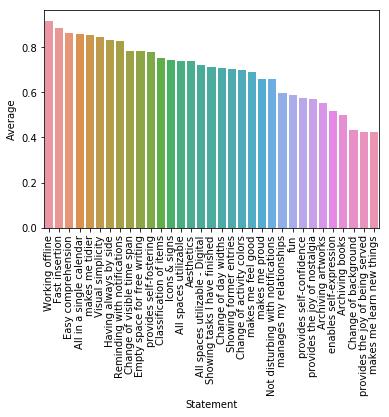

In [13]:
plot_avg = sns.barplot(x="Statement", y="Average", data=total_averages)
plot_avg.set_xticklabels(plot_avg.get_xticklabels(),rotation=90)
plot_avg

In [14]:
"""It is assumed that early adopters of a new app
should be already using their mobile phone & at least 3 other tools
for time management"""
mobile = df_clean["Mobile-phone"] == 1
atleast4 = df_clean["Total-Tool"] > 3
df_adopters = df_clean[mobile & atleast4]

In [15]:
#Calculating averages of statements, to see most wanted features
avg_list_a = df_adopters.iloc[:, 15:48].mean()
adopter_averages = pd.DataFrame({'Statement':avg_list_a.index, 'Average':avg_list_a.values})
adopter_averages = adopter_averages.sort_values("Average", ascending=False)

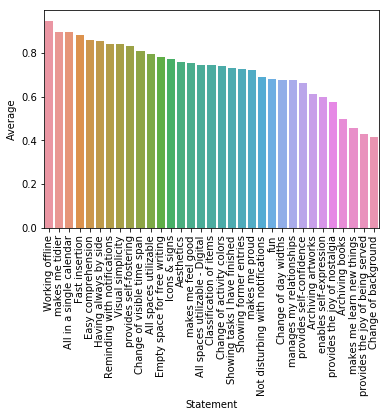

In [16]:
plot_adopters = sns.barplot(x="Statement", y="Average", data=adopter_averages)
plot_adopters.set_xticklabels(plot_adopters.get_xticklabels(),rotation=90)
plot_adopters

Top 7 features are the same for the all participants and early adopters. Therefore no special priorization is needed for early adopters.

In [30]:
#calculating correlations

#features vs features
df_corr_feature = df_clean.iloc[:, 15:48].corr()

#personal info vs features
df_corr = df_clean.drop(df_clean.iloc[:, 6:16], axis=1)

#personal info vs expectations
df_expectations = df_corr.drop(df_corr.iloc[:, 27:38], axis=1)

#personal info vs general expectaions
df_corr_general = df_expectations.drop(df_expectations.iloc[:, 20:28], axis=1).corr()

#personal info vs digital expectations
df_corr_digital = df_expectations.drop(df_expectations.iloc[:, 6:21], axis=1).corr()

#personal info vs motivations
df_corr_motivations = df_corr.drop(df_corr.iloc[:, 6:28], axis=1).corr()

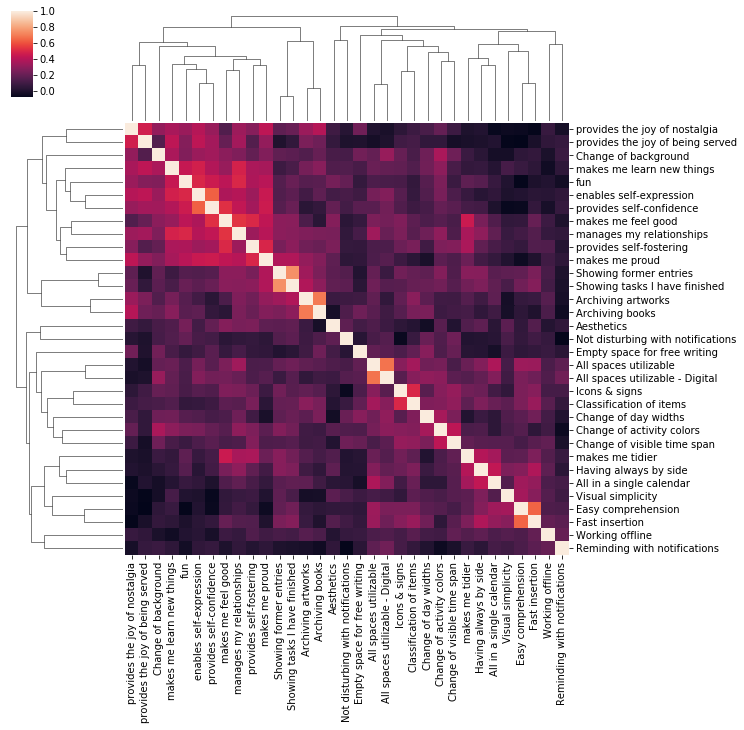

In [31]:
plot_corr_feature = sns.clustermap(df_corr_feature)
plot_corr_feature

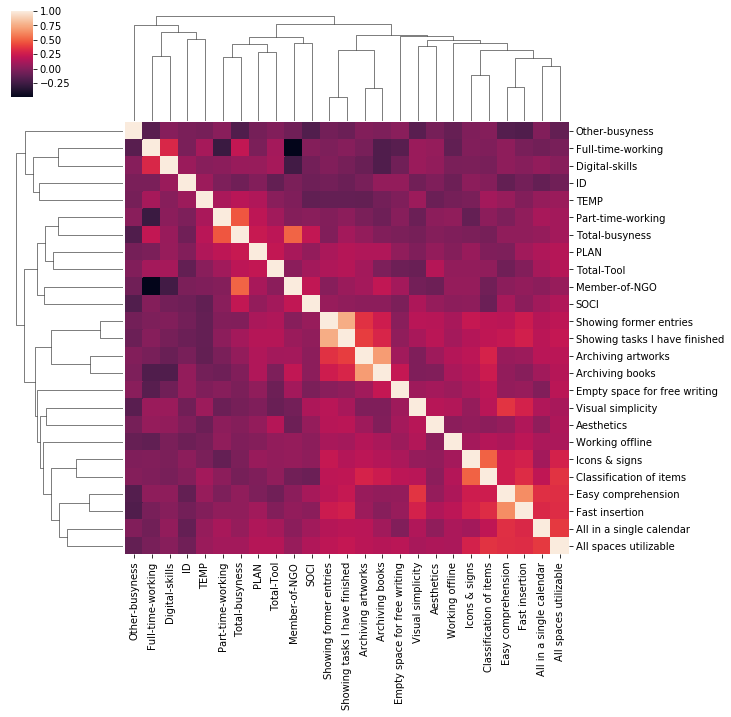

In [24]:
plot_corr_general = sns.clustermap(df_corr_general)
plot_corr_general

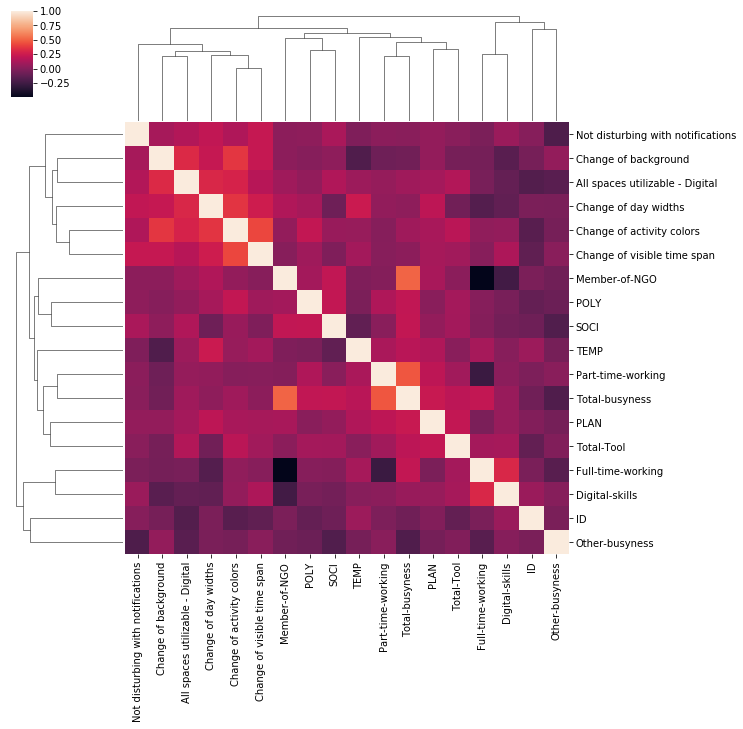

In [25]:
plot_corr_digital = sns.clustermap(df_corr_digital)
plot_corr_digital

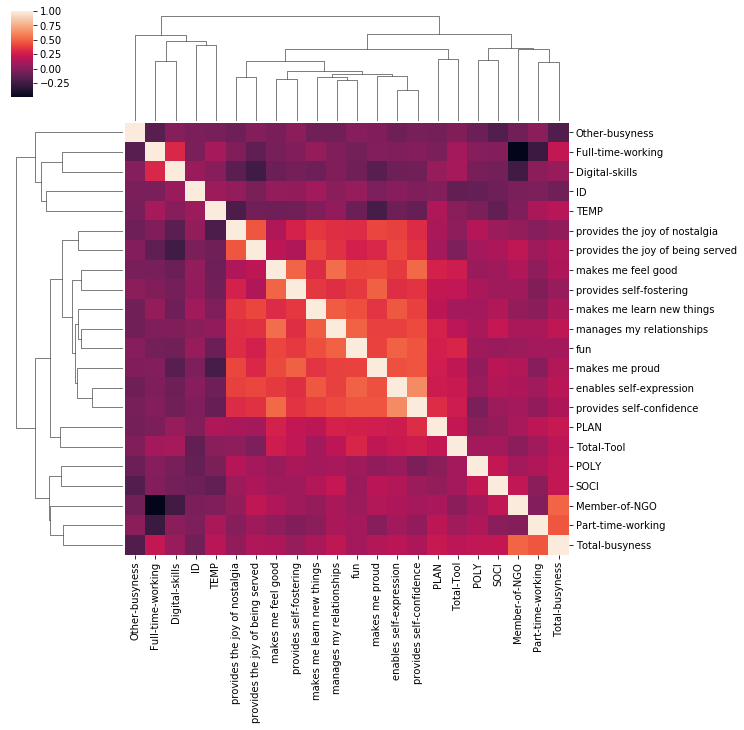

In [26]:
plot_corr_mot = sns.clustermap(df_corr_motivations)
plot_corr_mot